In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image

In [2]:
train_set=r'/kaggle/input/wlidata/SAVE/train'
val_set=r'/kaggle/input/wlidata/SAVE/val'
test_set=r'/kaggle/input/wlidata/SAVE/test'

In [3]:
train_datagen = image.ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
validation_datagen = image.ImageDataGenerator()
test_datagen = image.ImageDataGenerator()

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    val_set,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 4535 images belonging to 8 classes.
Found 1294 images belonging to 8 classes.
Found 661 images belonging to 8 classes.


In [5]:
train_generator.class_indices

{'dyed-lifted-polyps': 0,
 'dyed-resection-margins': 1,
 'esophagitis': 2,
 'normal-cecum': 3,
 'normal-pylorus': 4,
 'normal-z-line': 5,
 'polyps': 6,
 'ulcerative-colitis': 7}

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet101


class CustomGaussianNoise(tf.keras.layers.GaussianNoise):
    def __init__(self, stddev, **kwargs):
        super(CustomGaussianNoise, self).__init__(stddev, **kwargs)

    def get_config(self):
        config = super().get_config()
        config.update({"stddev": self.stddev})
        return config


base_model = ResNet101(weights='imagenet', input_shape=(224, 224, 3), include_top=False)


for layer in base_model.layers:
    layer.trainable = False


model = Sequential()
model.add(base_model)
model.add(CustomGaussianNoise(0.35))
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(CustomGaussianNoise(0.35))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.summary()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)               │ (None, 7, 7, 2048)          │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_gaussian_noise                │ (None, 7, 7, 2048)          │               0 │
│ (CustomGaussianNoise)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_gaussian_noise_1              │ (None, 256)                 │               0 │
│ (CustomGaussianNoise)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,185,800 (164.74 MB)

 Trainable params: 527,112 (2.01 MB)

 Non-trainable params: 42,658,688 (162.73 MB)

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True)
checkpoint = ModelCheckpoint('bestx_model.keras', monitor='val_loss', save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=75, min_lr=0.00001)


In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=300,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 159s 914ms/step - AUC: 0.7401 - Precision: 0.3990 - Recall: 0.2677 - accuracy: 0.3477 - loss: 6.6370 - val_AUC: 0.9635 - val_Precision: 0.7812 - val_Recall: 0.6695 - val_accuracy: 0.7297 - val_loss: 4.9364 - learning_rate: 1.0000e-04
Epoch 2/300
  1/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - AUC: 0.8891 - Precision: 0.6800 - Recall: 0.5312 - accuracy: 0.5625 - loss: 5.5377

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 0.8891 - Precision: 0.6800 - Recall: 0.5312 - accuracy: 0.5625 - loss: 5.5377 - val_AUC: 0.9552 - val_Precision: 0.6923 - val_Recall: 0.6429 - val_accuracy: 0.6429 - val_loss: 5.0386 - learning_rate: 1.0000e-04
Epoch 3/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 94s 635ms/step - AUC: 0.9288 - Precision: 0.6836 - Recall: 0.5839 - accuracy: 0.6365 - loss: 5.1842 - val_AUC: 0.9754 - val_Precision: 0.8143 - val_Recall: 0.7539 - val_accuracy: 0.7875 - val_loss: 4.4848 - learning_rate: 1.0000e-04
Epoch 4/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - AUC: 0.9299 - Precision: 0.7037 - Recall: 0.5938 - accuracy: 0.6250 - loss: 4.9488 - val_AUC: 0.9898 - val_Precision: 0.8333 - val_Recall: 0.7143 - val_accuracy: 0.7857 - val_loss: 4.3580 - learning_rate: 1.0000e-04
Epoch 5/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 96s 652ms/step - AUC: 0.9548 - Precision: 0.7389 - Recall: 0.6688 - accuracy: 0.7032 - loss: 4.6442 - val_AUC: 0.9786 - val_Precision: 0.8154 - val_Recal

In [10]:
train_evaluation = model.evaluate(train_generator)

142/142 ━━━━━━━━━━━━━━━━━━━━ 76s 538ms/step - AUC: 0.9973 - Precision: 0.9294 - Recall: 0.9221 - accuracy: 0.9266 - loss: 0.2756


In [11]:
val_evaluation = model.evaluate(validation_generator)

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - AUC: 0.9878 - Precision: 0.8570 - Recall: 0.8378 - accuracy: 0.8471 - loss: 0.4704


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Unique true labels: [0 1 2 3 4 5 6 7]
Unique predicted labels: [0 1 2 3 4 5 6 7]
Classes in test generator: ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus'

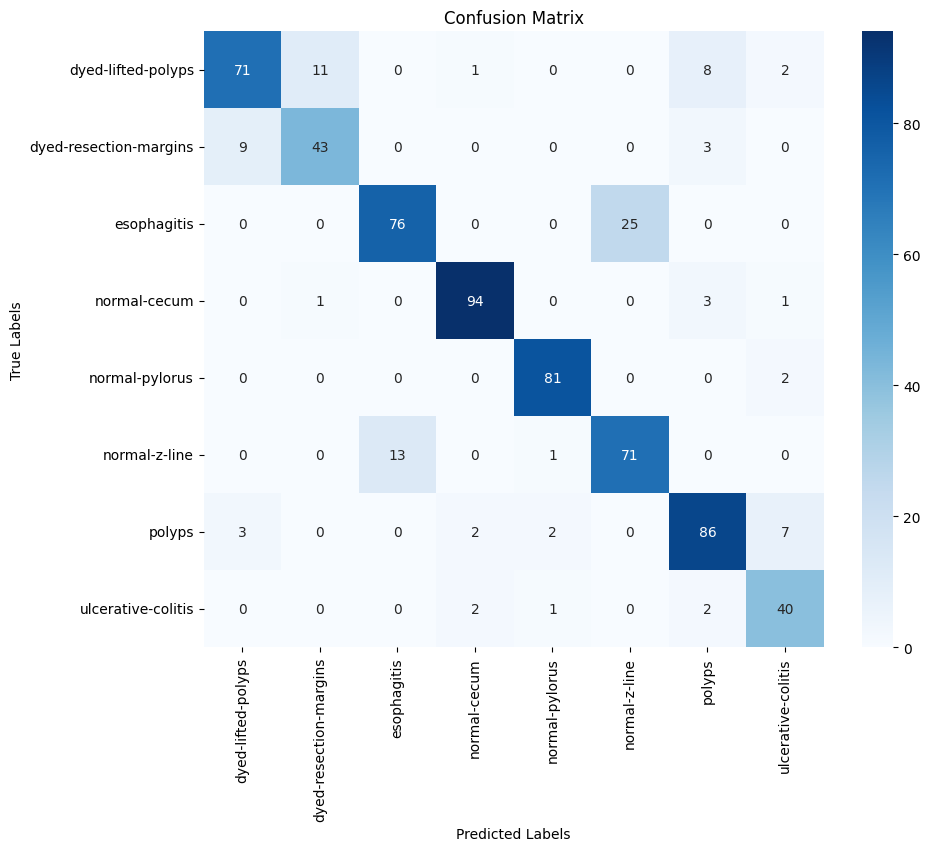

                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.86      0.76      0.81        93
dyed-resection-margins       0.78      0.78      0.78        55
           esophagitis       0.85      0.75      0.80       101
          normal-cecum       0.95      0.95      0.95        99
        normal-pylorus       0.95      0.98      0.96        83
         normal-z-line       0.74      0.84      0.78        85
                polyps       0.84      0.86      0.85       100
    ulcerative-colitis       0.77      0.89      0.82        45

              accuracy                           0.85       661
             macro avg       0.84      0.85      0.85       661
          weighted avg       0.85      0.85      0.85       661



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Reset the test generator
test_generator.reset()

# Prepare true and predicted labels
true_labels = []
predicted_probs = []

for i in range(len(test_generator)):
    imgs, labels = next(test_generator)
    true_labels.extend(np.argmax(labels, axis=1))
    predicted_probs.extend(np.argmax(model.predict(imgs), axis=1))

# Analyze unique classes in labels and generator
unique_classes = np.unique(true_labels)
print("Unique true labels:", unique_classes)
print("Unique predicted labels:", np.unique(predicted_probs))
print("Classes in test generator:", list(test_generator.class_indices.keys()))

# Adjust target names dynamically
if len(unique_classes) != len(test_generator.class_indices):
    print("Mismatch detected between classes in labels and generator.")
    target_names = [f"Class {i}" for i in unique_classes]
else:
    target_names = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_probs)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(
    true_labels,
    predicted_probs,
    labels=unique_classes,
    target_names=target_names
))


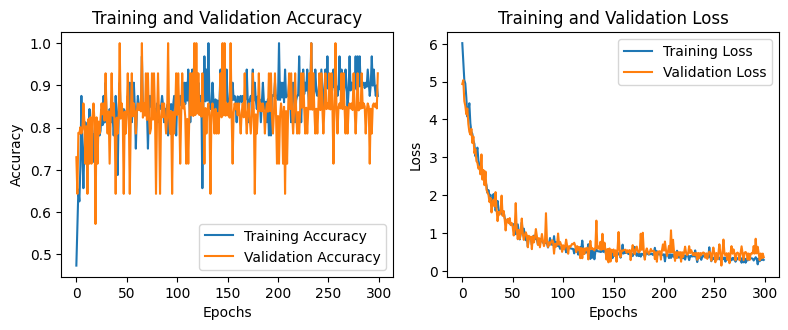

Final Epoch Metrics:
Final Training Accuracy: 0.8750
Final Validation Accuracy: 0.9286
Final Training Loss: 0.2931
Final Validation Loss: 0.3628


In [14]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

if 'precision' in history.history and 'val_precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()


if 'recall' in history.history and 'val_recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()


plt.tight_layout()
plt.show()


print("Final Epoch Metrics:")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

if 'precision' in history.history:
    print(f"Final Training Precision: {history.history['precision'][-1]:.4f}")
    print(f"Final Validation Precision: {history.history['val_precision'][-1]:.4f}")

if 'recall' in history.history:
    print(f"Final Training Recall: {history.history['recall'][-1]:.4f}")
    print(f"Final Validation Recall: {history.history['val_recall'][-1]:.4f}")

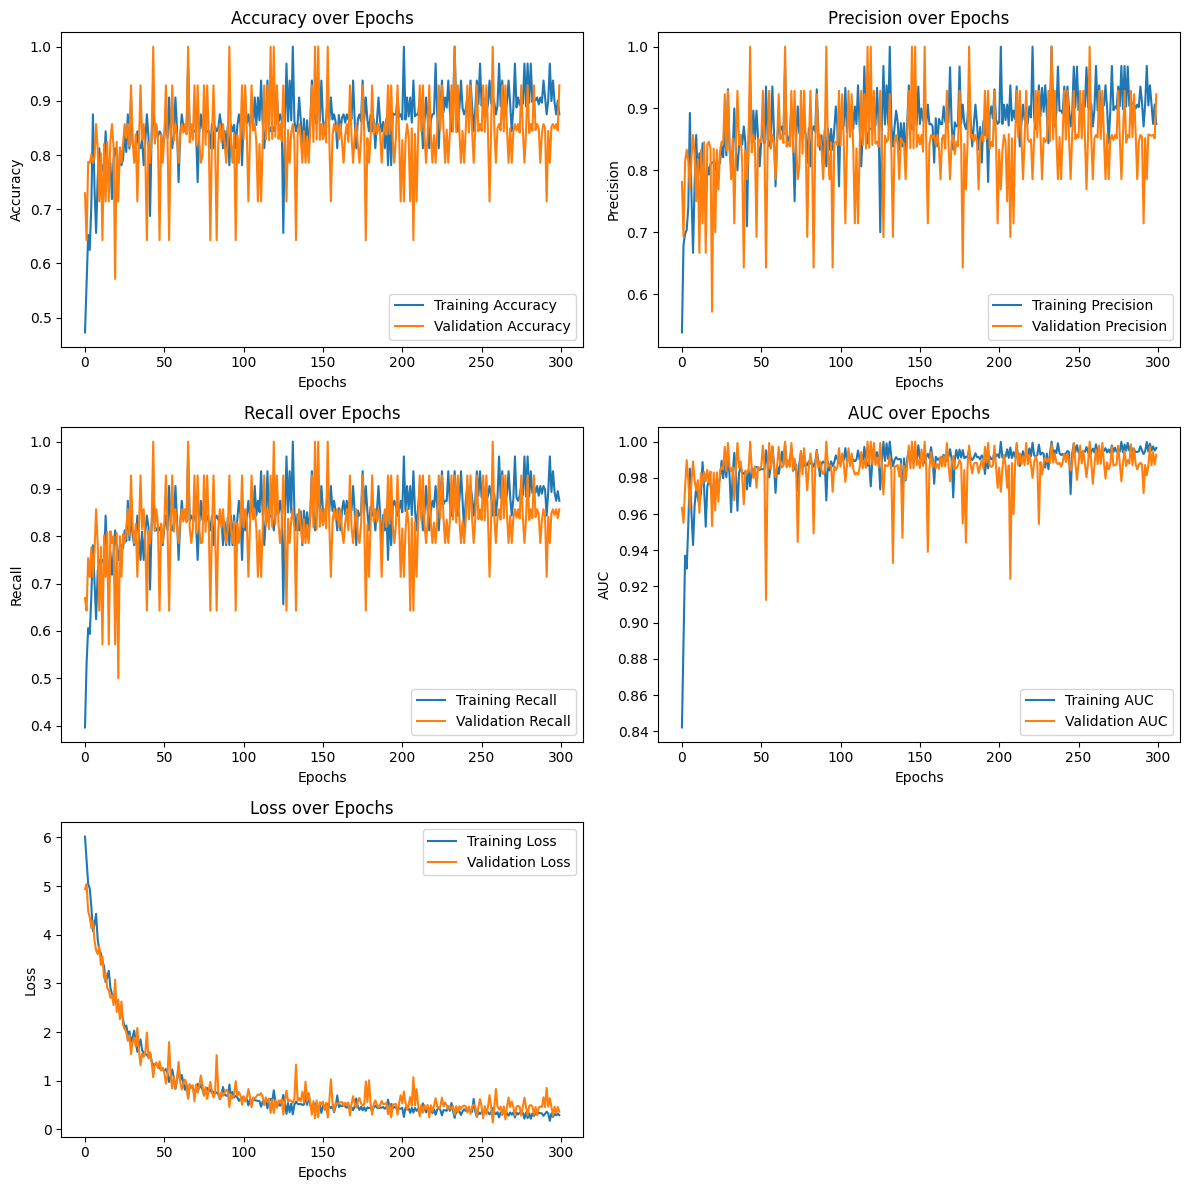

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))

# Accuracy plot
plt.subplot(3, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Precision plot
plt.subplot(3, 2, 2)
plt.plot(history.history['Precision'], label='Training Precision')
plt.plot(history.history['val_Precision'], label='Validation Precision')
plt.title('Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall plot
plt.subplot(3, 2, 3)
plt.plot(history.history['Recall'], label='Training Recall')
plt.plot(history.history['val_Recall'], label='Validation Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# AUC plot
plt.subplot(3, 2, 4)
plt.plot(history.history['AUC'], label='Training AUC')
plt.plot(history.history['val_AUC'], label='Validation AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

# Loss plot
plt.subplot(3, 2, 5)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


if 'lr' in history.history:
    plt.subplot(3, 2, 6)
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()


plt.tight_layout()
plt.show()